# Test the photometry functionality and compare output...

### Get background using sigma clipped stats

Mean: 2831.8837890625, Median: 2831.155517578125, SD: 61.87967300415039


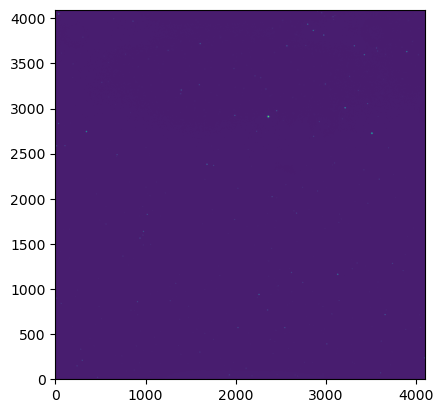

In [13]:
import photutils as pht
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt

data=fits.getdata('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit')
## here we can show some statistics about the sky
plt.imshow(data, origin='lower')
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
print(f"Mean: {mean}, Median: {median}, SD: {std}")

### get the background mask/map

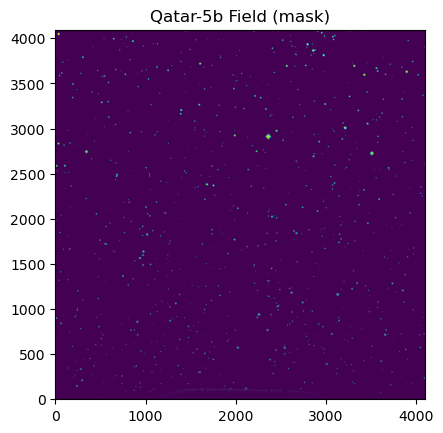

In [14]:
from photutils.segmentation import detect_sources
import matplotlib.pyplot as plt

segm = detect_sources(data-mean, 3*std, npixels=5)
#flipping here causes no issue, why does flipping data cause problems? should we flip flat/bias...
plt.imshow(segm.data, origin = 'lower')

plt.title("Qatar-5b Field (mask)")
plt.savefig("field_mask_plot.png")

### Convert the segmentation image to a numpy array, this can serve as mask, 

Text(0.5, 1.0, 'Boolean Sky Mask')

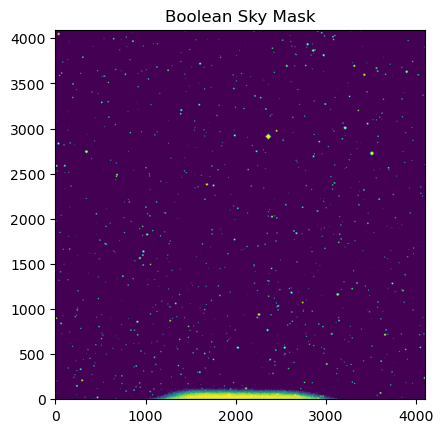

In [15]:
bool_array = segm.data != 0 
plt.imshow(bool_array, origin='lower')
plt.title('Boolean Sky Mask')

In [16]:
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = pht.background.SExtractorBackground()
bkg = pht.background.Background2D(data, (64, 64), mask=bool_array,filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

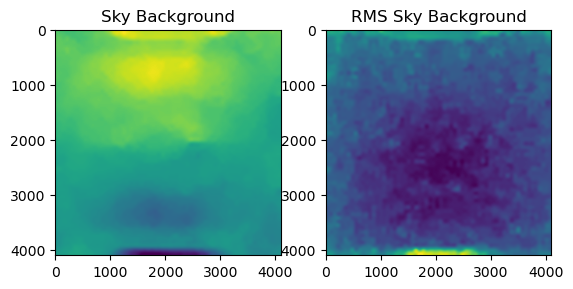

In [17]:
fig, axs = plt.subplots(1,2)
axs[0].set_title('Sky Background')
axs[0].imshow(bkg.background)
axs[1].set_title('RMS Sky Background')
axs[1].imshow(bkg.background_rms)

In [18]:
from photutils.detection import IRAFStarFinder

threshold_multiplier=15.0
daofind = IRAFStarFinder(fwhm=3.0, threshold=threshold_multiplier*bkg.background_rms_median,exclude_border=True, sharplo=0.5, sharphi=2.0, roundlo=0.0, roundhi=0.7)
sources = daofind(data - bkg.background_median)
print(sources)

 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  471.9253869850101 ...   46238.5556640625 -11.662510649337603
  2  2686.790425508937 ... 22075.305419921875 -10.859766802285302
  3 2970.7315842965827 ...     4404.544921875  -9.109752609266218
  4 2180.7980010276983 ...  15182.02001953125   -10.4533238994142
  5 3566.1533392700994 ...  5005.826904296875  -9.248689570327727
  6  2658.886895206944 ...     16681.27734375 -10.555573257556198
  7 1930.0162173931808 ...   63153.6455078125  -12.00099606253441
  8  2460.025365666135 ...  10826.87353515625 -10.086257659925073
  9  3604.710431795118 ...   71923.8271484375  -12.14218197160526
 10 2021.4186139623425 ...    3058.7646484375  -8.713865155507577
...                ... ...                ...                 ...
341 3077.8002313354714 ...   65999.2548828125 -12.048847581199006
342    2983.7346676783 ...    15157.005859375 -10.451533546251534
343  3098.

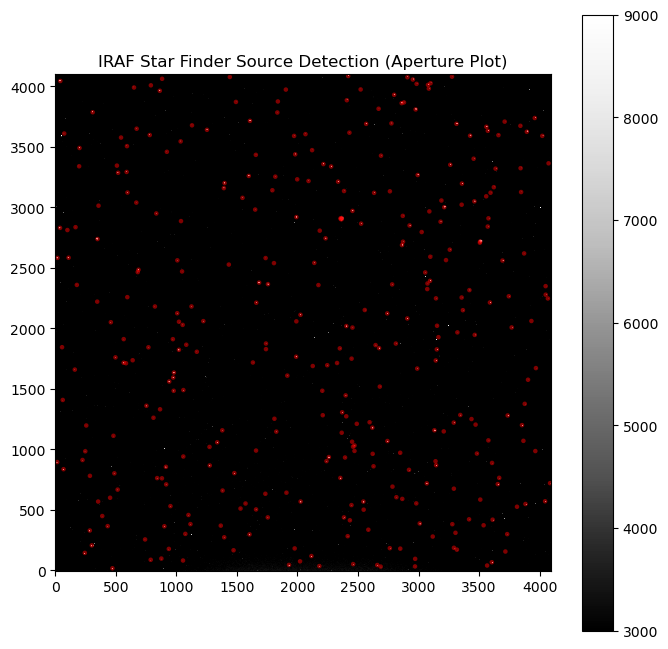

In [19]:
from photutils.aperture import CircularAperture
import numpy as np
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=10.)
plt.figure(figsize=(8,8))
plt.imshow(data, cmap='Greys_r', origin='lower', vmin=3000, vmax=9000, interpolation='nearest')
plt.colorbar()
plt.title("IRAF Star Finder Source Detection (Aperture Plot)")
apertures.plot(color='red', lw=1.5, alpha=0.5)

### Error estimation, including poisson error, for given image:

In [20]:
from photutils.utils import calc_total_error

gain=0.242759602
error=calc_total_error(data-bkg.background, bkg.background_rms, gain)
print(np.median(error))
print(sources)
print(sources.colnames)

49.86628
 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  471.9253869850101 ...   46238.5556640625 -11.662510649337603
  2  2686.790425508937 ... 22075.305419921875 -10.859766802285302
  3 2970.7315842965827 ...     4404.544921875  -9.109752609266218
  4 2180.7980010276983 ...  15182.02001953125   -10.4533238994142
  5 3566.1533392700994 ...  5005.826904296875  -9.248689570327727
  6  2658.886895206944 ...     16681.27734375 -10.555573257556198
  7 1930.0162173931808 ...   63153.6455078125  -12.00099606253441
  8  2460.025365666135 ...  10826.87353515625 -10.086257659925073
  9  3604.710431795118 ...   71923.8271484375  -12.14218197160526
 10 2021.4186139623425 ...    3058.7646484375  -8.713865155507577
...                ... ...                ...                 ...
341 3077.8002313354714 ...   65999.2548828125 -12.048847581199006
342    2983.7346676783 ...    15157.005859375 -10.451533546251534
3

### Photometry on all light frames in the processed directory:

In [ ]:
import glob
import os
from photutils.background import SExtractorBackground
from photutils.background import Background2D
from photutils.segmentation import detect_sources
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
#in function pass threshold multiplier... make the mask function....

light_frame_indicator = "lrp"
lights_processed=glob.glob(f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/*{light_frame_indicator}*')
threshold_multiplier = 15
lights_processed.sort() # in alphabetic order

radii=[3,4,5,6,8,10,12,15,20,25] ## aperture radii in pixels
total=len(lights_processed)

def background(file:str) -> pht.background.Background2D:
    data = fits.getdata(file)
    mean, _, std = sigma_clipped_stats(data, sigma=3.0)
    segm = detect_sources(data-mean, 3*std, npixels=5)
    bool_array = segm.data != 0
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = SExtractorBackground()
    bkg = Background2D(data, (64, 64), mask=bool_array,filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    return bkg

print(lights_processed)
for i,file in enumerate(lights_processed):
    print(f"Aperture photometry on all objects: file {i+1}/{total}")
    # catfile='/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/'+'_cat.fits'
    rootname,_=os.path.splitext(file)
    print(rootname)
    catfile=f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/{i+1}-cat.fits' #TODO: clean up paths for io
    print(file)
    bkg = background(file)
    daofind = pht.detection.IRAFStarFinder(fwhm=3.0, threshold=threshold_multiplier*bkg.background_rms_median,exclude_border=True, sharplo=0.5, sharphi=2.0, roundlo=0.0, roundhi=0.7)
    sources = daofind(data - bkg.background) #rms or full bkg?
    positions = [(ix,iy) for ix,iy in zip(sources['xcentroid'],sources['ycentroid'])] #list of tuples representing position...
    apertures = [pht.aperture.CircularAperture(positions, r=r) for r in radii] #list of apertures, one for each of the radii given (10 total...)
    error = calc_total_error(data-bkg.background, bkg.background_rms, gain)
    #aper_phot is a dictionary object of all the sources past the threshold
    aper_phot = pht.aperture.aperture_photometry(data - bkg.background, apertures, error=error)
    print(len(aper_phot))
    aper_phot.write(catfile,overwrite=True)

['/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_10.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_12.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_13.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_14.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_15.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_16.fit', '/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_17.fit', '/Users/spencerfreeman/Desktop/Person

/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

372
Aperture photometry on all objects: file 3/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

377
Aperture photometry on all objects: file 4/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_12
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_12.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

381
Aperture photometry on all objects: file 5/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_13
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_13.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

388
Aperture photometry on all objects: file 6/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_14
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_14.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

390
Aperture photometry on all objects: file 7/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_15
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_15.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

393
Aperture photometry on all objects: file 8/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_16
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_16.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

393
Aperture photometry on all objects: file 9/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_17
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_17.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

394
Aperture photometry on all objects: file 10/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_18
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_18.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

400
Aperture photometry on all objects: file 11/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_19
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_19.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

404
Aperture photometry on all objects: file 12/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_2
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_2.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

351
Aperture photometry on all objects: file 13/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_20
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_20.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

407
Aperture photometry on all objects: file 14/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_21
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_21.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

409
Aperture photometry on all objects: file 15/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_22
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_22.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

413
Aperture photometry on all objects: file 16/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_23
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_23.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

416
Aperture photometry on all objects: file 17/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_24
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_24.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

421
Aperture photometry on all objects: file 18/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_25
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_25.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

426
Aperture photometry on all objects: file 19/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_26
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_26.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

428
Aperture photometry on all objects: file 20/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_27
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_27.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

428
Aperture photometry on all objects: file 21/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_28
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_28.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

430
Aperture photometry on all objects: file 22/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_29
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_29.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

433
Aperture photometry on all objects: file 23/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_3
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_3.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

351
Aperture photometry on all objects: file 24/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_30
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_30.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

435
Aperture photometry on all objects: file 25/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_31
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_31.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

438
Aperture photometry on all objects: file 26/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_32
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_32.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

440
Aperture photometry on all objects: file 27/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_33
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_33.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

450
Aperture photometry on all objects: file 28/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_34
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_34.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

451
Aperture photometry on all objects: file 29/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_35
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_35.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

454
Aperture photometry on all objects: file 30/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_36
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_36.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

455
Aperture photometry on all objects: file 31/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_37
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_37.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

456
Aperture photometry on all objects: file 32/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_38
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_38.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

456
Aperture photometry on all objects: file 33/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_39
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_39.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

457
Aperture photometry on all objects: file 34/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_4
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_4.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

352
Aperture photometry on all objects: file 35/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_40
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_40.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

459
Aperture photometry on all objects: file 36/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_41
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_41.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

463
Aperture photometry on all objects: file 37/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_42
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_42.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

462
Aperture photometry on all objects: file 38/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_43
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_43.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

464
Aperture photometry on all objects: file 39/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_44.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

465
Aperture photometry on all objects: file 40/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_5
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_5.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

362
Aperture photometry on all objects: file 41/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_6
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_6.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

362
Aperture photometry on all objects: file 42/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_7
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_7.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

364
Aperture photometry on all objects: file 43/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_8
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_8.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

367
Aperture photometry on all objects: file 44/44
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_9
/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_9.fit


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

369


/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/convenience.py:661: AstropyUserWarning: Attribute `version` of type <class 'dict'> cannot be added to FITS Header - skipping
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture_photometry_args' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
  warnings.warn(
/opt/anaconda3/envs/pipeline_env/lib/python3.12/site-packages/astropy/io/fits/card.py:269: VerifyWarning: Keyword name 'aperture0_r' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH c

In [ ]:
head = fits.getheader('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_1-cat.fits')
#
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
hdulist = fits.open('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_11-cat.fits')
bin_table_hdu = hdulist[1] 
# Access the table data
table_data = bin_table_hdu.data
print(table_data)

[(  1, 2914.62150926,   10.7142912 ,   36719.72052152,  470.71743395,   56774.3665654 ,  599.06278598,   78440.17679734,  720.02838007,  101554.60520631,  836.42081742,  155415.81753675, 1067.82073108,  222740.24023101, 1303.40253432,  271195.58651924, 1525.90864221,   362833.43722441, 1820.66868414,   551612.64269405, 2279.63685438,   782328.53615218, 2724.45015356)
 (  2,  471.92539376,   17.90271359,  260513.34390734, 1068.94721545,  364512.80040427, 1274.80026812,  444017.53948403, 1422.01347963,  502214.64834336, 1531.92423479,  585096.66458596, 1704.2201842 ,  653951.40958528, 1861.67073924,  725146.23991583, 2024.47368814,   849583.93709551, 2288.11359698,  1047025.65544955, 2740.67898786,  1254567.81325696, 3147.89691481)
 (  3, 1779.04117842,   28.91405608,   20772.00154651,  390.44675657,   36268.53373762,  517.97993459,   55522.51597881,  643.81555034,   79574.75872087,  771.57096743,  140804.35019912, 1027.43461597,  218334.30325852, 1281.607222  ,  314293.64055559, 1537.78

### Take a look at two images side by side, to observe shifts qualatatively:

Text(0.5, 1.0, 'Exposure 40')

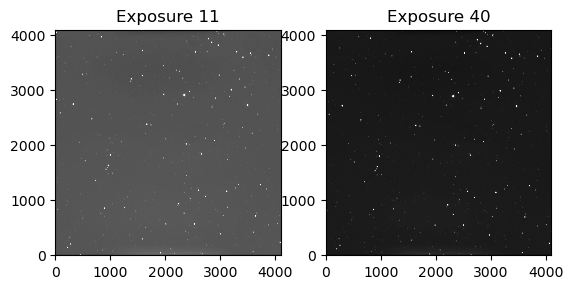

In [52]:
fig, axes = plt.subplots(1,2)
exposure = [11,40]
exposure1 = fits.getdata(f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_{exposure[0]}.fit')
exposure2 = fits.getdata(f'/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/qatar-5b_lrp_out_{exposure[1]}.fit')

#could subtract background -bkg.background but thats not really the point
axes[0].imshow(exposure1, origin='lower', vmin=1500, vmax=5000, cmap='Greys_r')
axes[0].set_title(f"Exposure {exposure[0]}")
axes[1].imshow(exposure2, origin='lower', vmin=1500, vmax=5000, cmap='Greys_r')
axes[1].set_title(f"Exposure {exposure[1]}")


35.0 34.0


Text(0.5, 1.0, 'y shift')

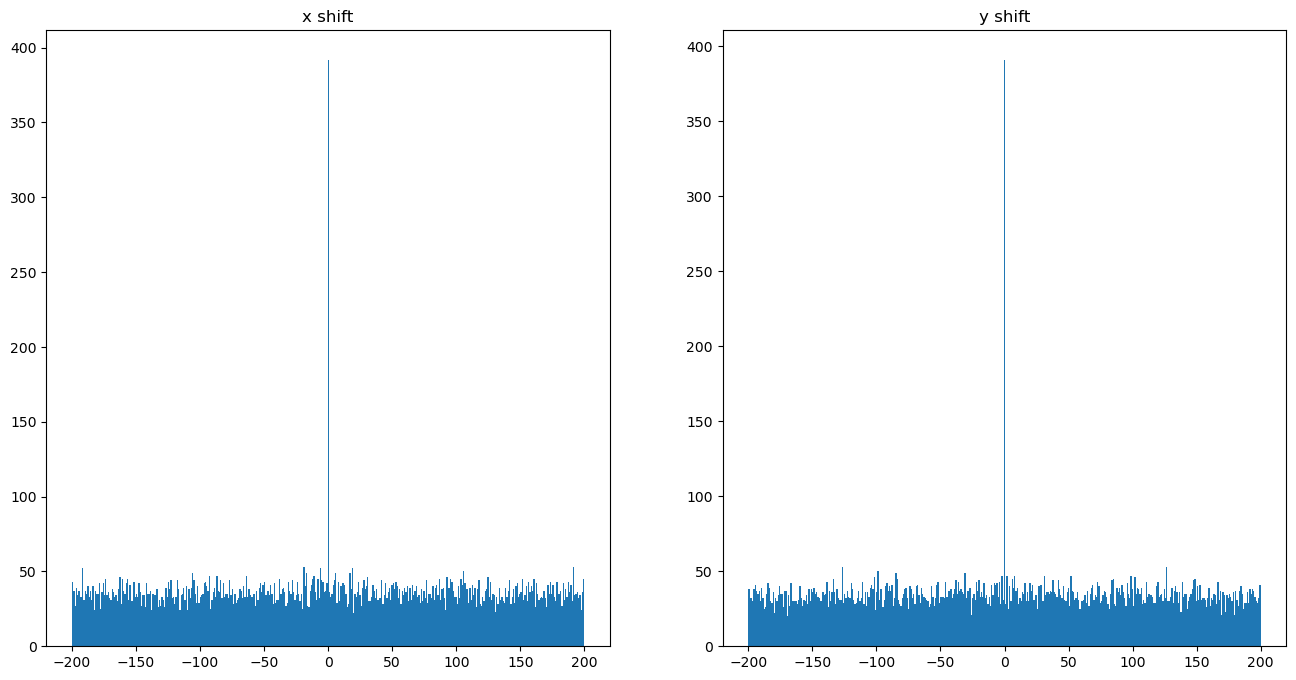

In [54]:
from astropy.table import Table

cat1 = Table.read('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/12-cat.fits')
cat2 = Table.read('/Users/spencerfreeman/Desktop/PersonalCS/CurrentPipeline/test_input/test_output/41-cat.fits')
x1=cat1['xcenter']
y1=cat1['ycenter']
x2=cat2['xcenter']
y2=cat2['ycenter']

ncat1=len(cat1)
ncat2=len(cat2)
XX=[]
YY=[]
for i in range(ncat2):
 XX.extend((x1-x2[i]))
 YY.extend((y1-y2[i]))
XX=np.array(XX)
YY=np.array(YY)
xhist,xbins=np.histogram(XX,range=[-200,200],bins=401)
yhist,ybins=np.histogram(YY,range=[-200,200],bins=401)
print(np.median(xhist),np.median(yhist))
f,axs=plt.subplots(1,2,figsize=(16,8))
axs[0].hist(XX,range=[-200,200],bins=401)
axs[0].set_title("x shift")
axs[1].hist(YY,range=[-200,200],bins=401)
axs[1].set_title("y shift")